# Time Series Forecasting

Using the acres burned dataframe, we will construct a forecast that will predict acres burned over the next 10 years. This will then be used to create predictions for wildfire suppression costs and structures destroyed.

We want to insert a caveat here: we are not climate scientists, and this is not a climate science-based model. We are making a handful of assumptions here that should all be taken into account, including:
- Historical acres burned can be used as a proxy to predict future acres burned
- The mean cost per acre, using the 513 individual fires from the "fires_clean_df" dataset, can be used to project future costs
- The mean structure destroyed per acre, using the 513 individual fires from the "fires_clean_df" dataset, can be used to project future structures destroyed

In [1]:
# Check conda environment - should be sktime
!conda env list

# conda environments:
#
base                     /Users/claireph/opt/anaconda3
sktime                *  /Users/claireph/opt/anaconda3/envs/sktime



In [117]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import EnsembleForecaster

import pmdarima as pmd
from pmdarima.utils import tsdisplay


from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [3]:
acres_df = pd.read_csv('./01_data_collection/claire_data/acres_clean.csv', index_col='Unnamed: 0')

In [4]:
acres_df.tail()

,acres_burned
2016,5.402921e+05
2017,1.415352e+06
2018,1.584802e+06
2019,2.753229e+05
2020,4.149345e+06


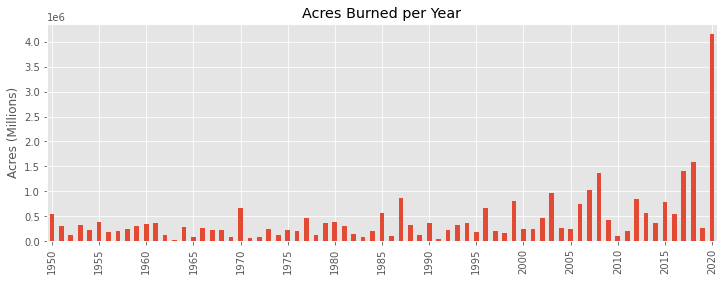

In [116]:
# Code source: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib/12608937
acres_df['acres_burned'].plot(kind='bar', figsize=(12,4))
plt.xticks(np.arange(0, 71, 5.0))
plt.title('Acres Burned per Year')
plt.ylabel('Acres (Millions)');

In [6]:
y = acres_df['acres_burned'].reset_index(drop=True)
y

0     5.375387e+05
1     3.057212e+05
2     1.323705e+05
3     3.338548e+05
4     2.187340e+05
          ...     
66    5.402921e+05
67    1.415352e+06
68    1.584802e+06
69    2.753229e+05
70    4.149345e+06
Name: acres_burned, Length: 71, dtype: float64

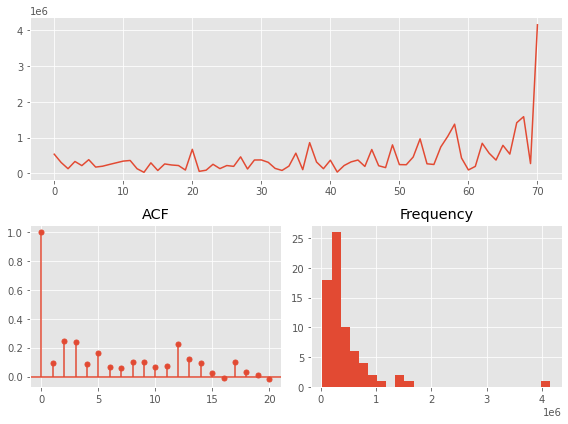

In [48]:
tsdisplay(y, lag_max=20);

**Autocorrelation:** From the ACF plot above, we can see that there is a degree of correlation to past acres burned, though the correlation isn't particularly strong.

### Model Selection

We will begin by using a temporal train/test/split method to test out a number of different models. Then we will ensemble the two best models (based on MAE) to build predictions for the next 10 years.

In [54]:
y_train, y_test = temporal_train_test_split(y, test_size=15)

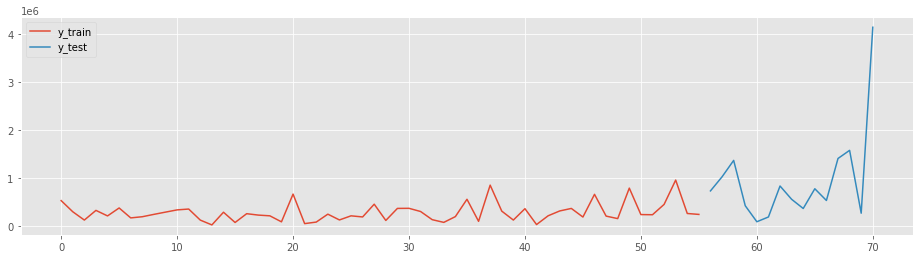

In [55]:
plot_ys(y_train, y_test, labels=['y_train', 'y_test']);

In [56]:
naive_model_mean = NaiveForecaster(strategy='mean')
naive_model_mean.fit(y_train)
y_preds_mean = naive_model_mean.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_mean)

708611.8512042619

In [105]:
naive_model_season = NaiveForecaster(strategy='last', sp=5)
naive_model_season.fit(y_train)
y_preds_season = naive_model_season.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_season)

602886.7150199999

In [102]:
sarima_model = AutoARIMA(sp=10, suppress_warnings=True)
sarima_model.fit(y_train)
y_preds_sarima = sarima_model.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_sarima)

708611.8512042619

In [103]:
hw_model = AutoETS(auto=True, sp=10)
hw_model.fit(y_train.astype('float'))
y_preds_hw = hw_model.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_hw)

595140.5962298686

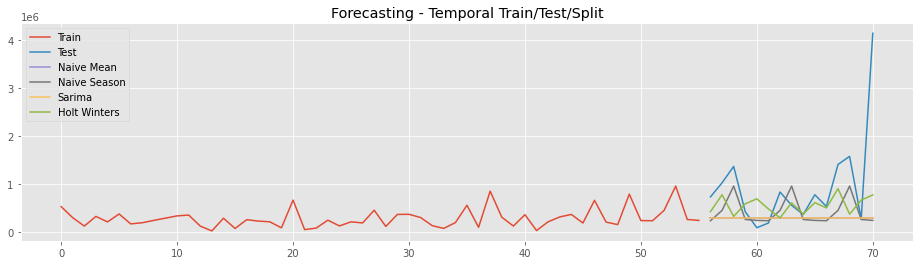

In [106]:
plot_ys(y_train, y_test, y_preds_mean, y_preds_season, y_preds_sarima, y_preds_hw,
        labels=['Train', 'Test', 'Naive Mean', 'Naive Season', 'Sarima', 'Holt Winters']);
plt.title('Forecasting - Temporal Train/Test/Split');

### Future Forecasting Models

In [118]:
# Ensembling 2 best methods
forecaster = EnsembleForecaster([
        ('seasonal', naive_model_season_ext),
        ('hw', hw_model)
        ],
    n_jobs=-1
)

In [119]:
forecaster.fit(y)

EnsembleForecaster(forecasters=[('seasonal', NaiveForecaster(sp=5)),
                                ('hw', AutoETS(auto=True, sp=10))])

In [126]:
y_preds_ens = forecaster.predict(list(range(1, 11)))

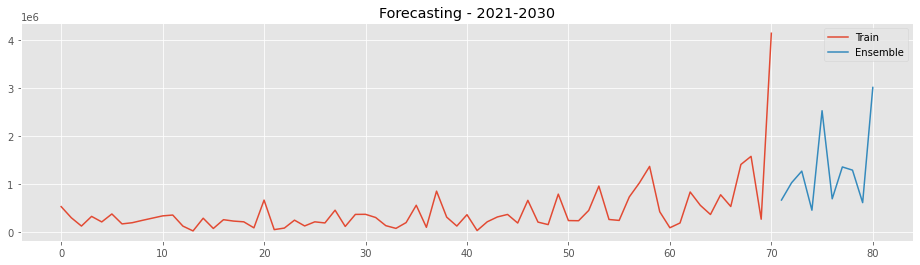

In [128]:
plot_ys(y, y_preds_ens, labels = ['Historical', 'Ensemble']);
plt.title('Forecasting - 2021-2030');

In [149]:
ens_predictions_df = pd.DataFrame(
    {'year': list(range(2021, 2031)),
     'pred_acres': y_preds_ens})

In [150]:
# Source: https://pbpython.com/styling-pandas.html
ens_predictions_df['pred_cost'] = ens_predictions_df['pred_acres'] * 3072.86
ens_predictions_df['pred_structures_destroyed'] = ens_predictions_df['pred_acres'] * 0.0047
format_dict = {'pred_acres': '{0:,.0f}', 'pred_cost':'${0:,.0f}', 'pred_structures_destroyed': '{0:,.2f}'}

ens_predictions_df.style.format(format_dict).hide_index()

year,pred_acres,pred_cost,pred_structures_destroyed
2021,"674,596","$2,072,940,163","3,170.60"
2022,"1,035,928","$3,183,260,947","4,868.86"
2023,"1,276,574","$3,922,734,331","5,999.90"
2024,"462,936","$1,422,536,732","2,175.80"
2025,"2,535,220","$7,790,374,995","11,915.53"
2026,"700,427","$2,152,314,696","3,292.01"
2027,"1,363,949","$4,191,223,781","6,410.56"
2028,"1,297,395","$3,986,712,305","6,097.76"
2029,"620,385","$1,906,356,697","2,915.81"
2030,"3,020,475","$9,281,497,561","14,196.23"


In [133]:
ens_predictions_df['pred_cost'].sum()

39909952207.60301

In [145]:
ens_predictions_df['pred_structures_destroyed'].sum()

61043.05935699451

In [147]:
ens_predictions_df['pred_acres'].sum()

12987884.969573298